# SigE second part of putative binding motif

- check if the high scoring motif found at centers of sigE peaks has second part
- we will treat the motif as possible -10 or -35 part and look for conserved motif at expected distance
---

In [1]:
import pandas as pd
from Bio import SeqIO
import os
import shutil
import meme_txt_parser
import subprocess
from IPython.display import display, Image
from Bio import SeqUtils

SC_ACCESSION = "AL645882.2"
temp = 'new_motif_site'


In [2]:
# load genome
sc_genome = [
    s for s in SeqIO.parse('data/GCA_000203835.1_ASM20383v1_genomic.fna', format='fasta') if s.id == SC_ACCESSION
][0]

# load found MOTIF 1 sites

In [3]:
m10_dir = 'peak_summit_motif_discovery'

df = pd.read_excel(m10_dir + '/sigE_motif_discovery.xlsx', sheet_name='sigE-motif', skiprows=range(14))
df

,motif_id,sequence_name,strand,start,P-value,site,sequence_offset,stop,downstream_gene,distance_to_downstream
0,MEME-1,sigE_181,+,16,0.000046,GAAGACG,2088569,23,SCO1954,1617.0
1,MEME-1,sigE_171,+,53,0.000046,GAAGACG,3659392,60,SCO3310,2285.0
2,MEME-1,sigE_168,+,81,0.000046,GAAGACG,4074167,88,SCO3696,1683.0
3,MEME-1,sigE_156,-,43,0.000046,GAAGACG,6883700,50,SCO6255,5568.0
4,MEME-1,sigE_154,+,51,0.000046,GAAGACG,7631695,58,SCO6885,22393.0
...,...,...,...,...,...,...,...,...,...,...
82,MEME-1,sigE_116,-,42,0.000339,ATAGACG,3064610,49,SCO2806,88.0
83,MEME-1,sigE_178,-,53,0.000394,GTAGATG,2645931,60,SCO2458,563.0
84,MEME-1,sigE_158,+,49,0.000394,AAATAAG,6509941,56,SCO5943,28.0
85,MEME-1,sigE_187,-,36,0.000404,ATAGAAG,490356,43,SCO0468,42.0


In [4]:
# prepare for motig reverse complemet

df_rc = df.copy()
df_rc.loc[df.strand == '+', 'strand'] = '-'
df_rc.loc[df.strand == '-', 'strand'] = '+'

In [5]:
os.environ["JUPYTER_TEMP"] = temp
os.environ["M10DIR"] = m10_dir

shutil.rmtree(temp, ignore_errors=True)
os.makedirs(temp)

In [6]:
# set possition relative to identified motif site
# either a) upstream b) downstream


# a) upstream

def upstream_from_motif(genome, df, offset=15, segment_len=10):
    upstream_segments = []
    for r in df.itertuples():
        motif_s = r.sequence_offset -1 + r.start
        motif_e = r.sequence_offset -1 + r.stop
        if r.strand == '+':
            e = motif_s - offset
            s = e - segment_len

            segment = genome[s:e]

        elif r.strand == '-':
            s = motif_e + offset
            e = s + segment_len

            segment = genome[s:e].reverse_complement()

        else:
            raise NotImplementedError()

        segment.id = r.sequence_name + '-{}_{}-{}'.format(r.strand, s, len(segment))
        segment.description = ''
        segment.name = ''
        upstream_segments.append(segment)   
    return upstream_segments


# b) downstream
def downstream_from_motif(genome, df, offset=15, segment_len=10):
    downstream_segments = []
    for r in df.itertuples():
        motif_s = r.sequence_offset -1 + r.start
        motif_e = r.sequence_offset -1 + r.stop
        if r.strand == '+':
            s = motif_e + offset
            e = s + segment_len

            segment = genome[s:e]

        elif r.strand == '-':
            e = motif_s - offset
            s = e - segment_len

            segment = genome[s:e].reverse_complement()

        else:
            raise NotImplementedError()


        segment.id = r.sequence_name + '-{}_{}-{}'.format(r.strand, s, len(segment))
        segment.description = ''
        segment.name = ''
        downstream_segments.append(segment)
    return downstream_segments


In [7]:
upstream_segments = upstream_from_motif(sc_genome, df, 13, 14)
downstream_segments = downstream_from_motif(sc_genome, df, 13, 14)

upstream_segments_from_rc = upstream_from_motif(sc_genome, df_rc, 13, 14)
downstream_segments_from_rc = downstream_from_motif(sc_genome, df_rc, 13, 14)

In [8]:
SeqIO.write(upstream_segments, os.path.join(temp, 'upstream_segments.fasta'), format='fasta')
SeqIO.write(downstream_segments, os.path.join(temp, 'downstream_segments.fasta'), format='fasta')

SeqIO.write(upstream_segments_from_rc, os.path.join(temp, 'upstream_segments_from_rc.fasta'), format='fasta')
SeqIO.write(downstream_segments_from_rc, os.path.join(temp, 'downstream_segments_from_rc.fasta'), format='fasta')

87

In [9]:
%%bash

meme -oc $JUPYTER_TEMP/upstream -mod zoops -nmotifs 3 -minw 4 -maxw 8 -dna -allw -bfile $M10DIR/AL645882.2_m1.markov $JUPYTER_TEMP/upstream_segments.fasta
meme -oc $JUPYTER_TEMP/downstream -mod zoops -nmotifs 3 -minw 4 -maxw 8 -dna -allw -bfile $M10DIR/AL645882.2_m1.markov $JUPYTER_TEMP/downstream_segments.fasta

meme -oc $JUPYTER_TEMP/upstream_from_rc -mod zoops -nmotifs 3 -minw 4 -maxw 8 -dna -allw -bfile $M10DIR/AL645882.2_m1.markov $JUPYTER_TEMP/upstream_segments_from_rc.fasta
meme -oc $JUPYTER_TEMP/downstream_from_rc -mod zoops -nmotifs 3 -minw 4 -maxw 8 -dna -allw -bfile $M10DIR/AL645882.2_m1.markov $JUPYTER_TEMP/downstream_segments_from_rc.fasta

Writing results to output directory 'new_motif_site/upstream'.
BACKGROUND: using background model of order 1
PRIMARY (classic): n 87 p0 87 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 1218 highwater mark: seq 87 pos 10
BALANCE: samples 87 chars 1218 nodes 1 chars/node 1218
Initializing the motif probability tables for 2 to 87 sites...
nsites = 87
Done initializing.
all widths from min to max

seqs=    87, min_w=  14, max_w=   14, total_size=     1218

motif=1
SEED DEPTHS: 2 4 8 16 32 64 87
SEED WIDTHS: 4 5 6 7 8
em: w=   8, psites=  87, iter=  40 
motif=2
SEED DEPTHS: 2 4 8 16 32 64 87
SEED WIDTHS: 4 5 6 7 8
em: w=   8, psites=  87, iter=  40 
motif=3
SEED DEPTHS: 2 4 8 16 32 64 87
SEED WIDTHS: 4 5 6 7 8
em: w=   8, psites=  87, iter=  40 
Writing results to output directory 'new_motif_site/downstream'.
BACKGROUND: using background model of order 1
PRIMARY (classic): n 87 p0 87 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Tri

In [10]:
### Check results of the motif discovery ###
# the upstream from rc is the -35 part of Tran motif

m35 = meme_txt_parser.read_file(os.path.join(temp, 'upstream_from_rc', 'meme.txt'), no_strand=True)
m10 = meme_txt_parser.read_file(os.path.join(m10_dir, 'meme_zoops_test/meme.txt'))

In [11]:
def _get_strand(r, retval='offset'):
    s = r.sequence_name
    
    _b = s.split('_')
    strand = _b[1][-1]
    offset = int(_b[2].split('-')[0])
    sl = int(_b[2].split('-')[1])
    sequence_name = s.split('-')[0]
        
    return vars()[retval]

m35['strand'] = m35.apply(_get_strand, retval='strand', axis=1)
m35['offset'] = m35.apply(_get_strand, retval='offset', axis=1)
m35['segment_length'] = m35.apply(_get_strand, retval='sl', axis=1)
m35['sequence_name'] = m35.apply(_get_strand, retval='sequence_name', axis=1)

In [12]:
ss = []
ee = []
for r in m35.itertuples():
    if r.strand == '+':
        s = r.offset+r.start-1
        e = r.offset+r.start+len(r.site)-1
        assert str(sc_genome.seq[s:e]) == r.site
    elif r.strand == '-':
        s = r.offset+(r.segment_length-len(r.site)-r.start+1)
        e = r.offset+r.segment_length-r.start+1
        assert str(sc_genome.seq[s:e].reverse_complement()) == r.site
    else:
        raise NotImplementedError()
    ss.append(s)
    ee.append(e)
m35['ss'] = ss
m35['ee'] = ee

In [13]:
m10['offset'] = m10.sequence_name.apply(lambda x: int(x.split('-')[1]))
m10.sequence_name = m10.sequence_name.apply(lambda x: x.split('-')[0])


In [14]:
ss = []
ee = []
for r in m10.itertuples():
    if r.strand == '+':
        s = r.offset+r.start-1
        e = r.offset+r.start+len(r.site)-1
        assert str(sc_genome.seq[s:e]) == r.site
    elif r.strand == '-':
        s = r.offset+r.start-1
        e = r.offset+r.start+len(r.site)-1
        assert str(sc_genome.seq[s:e].reverse_complement()) == r.site
    ss.append(s)
    ee.append(e)
m10['ss'] = ss
m10['ee'] = ee

In [15]:
strand_invert = {'-': '+', '+': '-'}
m10.strand = m10.strand.apply(lambda x: strand_invert[x])

m10.head()

,motif_id,sequence_name,strand,start,P-value,_site_left,site,_site_right,offset,ss,ee
0,MEME-1,sigE_181,-,16,0.000046,GCCCGTCCTC,GAAGACG,ACCATGGAGG,2088569,2088584,2088591
1,MEME-1,sigE_171,-,53,0.000046,TGCCGCCCAG,GAAGACG,TCGTAGACCC,3659392,3659444,3659451
2,MEME-1,sigE_168,-,81,0.000046,GCTGATCGGC,GAAGACG,ACCGCGAGGC,4074167,4074247,4074254
3,MEME-1,sigE_156,+,43,0.000046,GCCCCGCCAG,GAAGACG,TCGAGACCGG,6883700,6883742,6883749
4,MEME-1,sigE_154,-,51,0.000046,CGTCGATCAA,GAAGACG,GTCATAGGCG,7631695,7631745,7631752


In [16]:
m35.head()

,motif_id,sequence_name,start,P-value,_site_left,site,_site_right,strand,offset,segment_length,ss,ee
0,MEME-1,sigE_129,7,0.000032,CCGGGC,CAACGTTT,NaN,+,2502720,14,2502726,2502734
1,MEME-1,sigE_154,5,0.000047,ATGG,GAACCGTA,TC,-,7631765,14,7631767,7631775
2,MEME-1,sigE_10,7,0.000077,GCTGTG,GAACGTCA,NaN,+,7565221,14,7565227,7565235
3,MEME-1,sigE_26,1,0.000077,.,GAACGTCA,ACTTCT,+,6720644,14,6720644,6720652
4,MEME-1,sigE_21,7,0.000104,GCGGGC,GAACGGTT,NaN,-,7016731,14,7016731,7016739


In [17]:
_m10 = m10.loc[m10.motif_id == 'MEME-1', ['sequence_name', 'strand', 'ss', 'ee']]
_m35 = m35.loc[m35.motif_id == 'MEME-1', ['sequence_name', 'strand', 'ss', 'ee']]

mm = pd.merge(_m35, _m10, on=['sequence_name', 'strand'], suffixes=['_m35', '_m10'])

dd = []
for r in mm.itertuples():
    if r.strand == '+':
        d = r.ss_m10 - r.ee_m35
    elif r.strand == '-':
        d = r.ss_m35 - r.ee_m10
    else:
        raise NotImplementedError()
    dd.append(d) 
mm['dist'] = dd

In [18]:
# extract motif sites
# check thi sites
fw = str(sc_genome.seq)
rc = str(sc_genome.seq.reverse_complement())
promoters = []
max_dist = mm.dist.max()
for r in mm.itertuples():
    
    if r.strand == '+':
        promoter = str(sc_genome.seq[r.ss_m35:r.ee_m35]) + str(sc_genome.seq[r.ee_m35:r.ss_m10]) + '-'*(max_dist-r.dist) + str(sc_genome.seq[r.ss_m10:r.ee_m10])
    elif r.strand == '-':
        promoter = ''.join([
            str(sc_genome.seq[r.ss_m35:r.ee_m35].reverse_complement()),
            str(sc_genome.seq[r.ee_m10:r.ss_m35].reverse_complement()) + '-'*(max_dist-r.dist),
            str(sc_genome.seq[r.ss_m10:r.ee_m10].reverse_complement())
        ])
    else:
        raise NotImplementedError()
    
    promoters.append(promoter)
    
    if promoter.replace('-', '') in fw:
        pass
    elif promoter.replace('-', '') in rc:
        pass
    else:
        AssertionError('not found')
    print(promoter)
        

CAACGTTTCCGTTCGAATTAT------CGTCTTC
GAACCGTATCTGTCGCCTATGAC----CGTCTTC
GAACGTCATAGCCGTCTGGTG------CGTCTAC
GAACGTCAACTTCTTCAACCCGGACGCCGTCTAC
GAACGGTTTCCTCTCCCCCGT------CATCTTC
CAACCGTTCGATGCCCCGGAA------CGTCTTC
CAACGTCTCGCGCGCCTACGG------CGTCTTC
GAACCCTTCGCTTGTCCCTGTG-----CGTCTTG
CAACGGTACGCCCCGGTTACTGGA---CCTCTTC
CAACCGCACGTACGCGGAGAACGT---CTTCTTC
CAACATCTCCTCCTTCAACAC------CGTCTTC
GAACGACTACCTGGTCGCCAC------CGTCTTC
GAACGTTCCTCACTCCGCCAT------CGTCTAC
CAACGGCACGCTGCAGACCGA------CATCTTC
CAACCTCGCGCAGCCCCTCAC------CGTCTTG
GAACCAGTAGGTATGTCGTTCT-----CGTCTTC
GAACCGAACCGGTTCCCGTGG------CGTATTC
CAACCCGAGGGGCGATGCCCG------CGTCTAT
GAACCCTCAGCCTCCTCAGAC------CCTCTTC
CAACCTGGTCCCCGTTTTCGT------CGTCTTC
GAACGGCGAGCGCGGCCGCACCGT---CTTCTTC
CAACCACGGGACCGGGTCGAG------CGTCTTT
GAACGACGTGCAGGCGGCGGA------CGTCTTC
GAACGCAACCCGGCGGTCTACGATGC-CATCTTC
CAACCTGCACGGGGCGTACGA------CTTCTTC
CAACCCTCAGGCGGTACGGGC------CGTCTTC
GAAGCTCTCATCTCGTTGTCAG-----CTTCTTT
GAACCGGGAGACCTGCTCGAT------CGTCTTC
GAACACGACGTTCGGGGAGA

In [19]:
# use only spacers 16-19 counting between AACC and TCTTC

motif_dir = 'high_scoring_sites'
os.makedirs(os.path.join(temp, motif_dir), exist_ok=True)

p_variants = [
    (22, 27, '19'),
    (21, 27, '18'),
    (20, 27, '17'),
    (19, 27, '16')
]
for p in p_variants:
    pms = [s[:p[0]] + s[p[1]:] for s in promoters]
    
    with open(os.path.join(temp, motif_dir, 'hsm_{}.txt'.format(p[2])), 'w') as t:
        t.write('\n'.join(pms) + '\n')
        

In [20]:
motifs = ['hsm_{}'.format(p[2]) for p in p_variants]

In [21]:
SeqIO.write([sc_genome], os.path.join(temp, 'AL645882.2.fasta'), format='fasta')

1

In [22]:
%%bash
fasta-get-markov -m 1 $JUPYTER_TEMP/AL645882.2.fasta > $JUPYTER_TEMP/AL645882.2_m1.markov
sites2meme -bg $JUPYTER_TEMP/AL645882.2_m1.markov $JUPYTER_TEMP/high_scoring_sites > $JUPYTER_TEMP/high_scoring_sites.meme

Converted 4 motifs.
0 conversion errors.


hsm_19


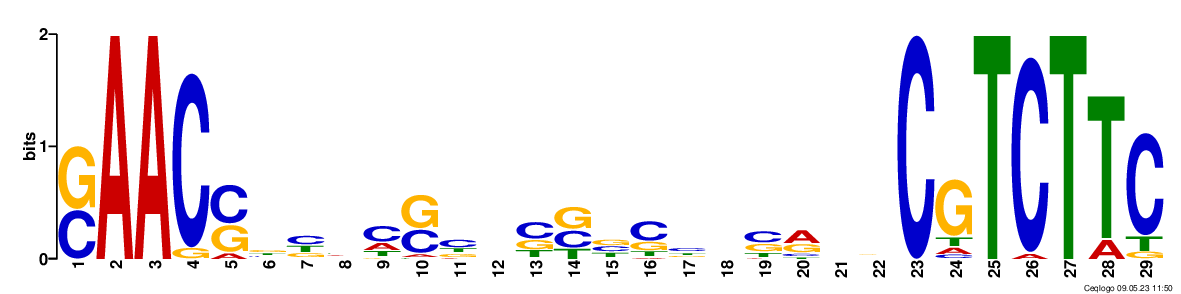

hsm_18


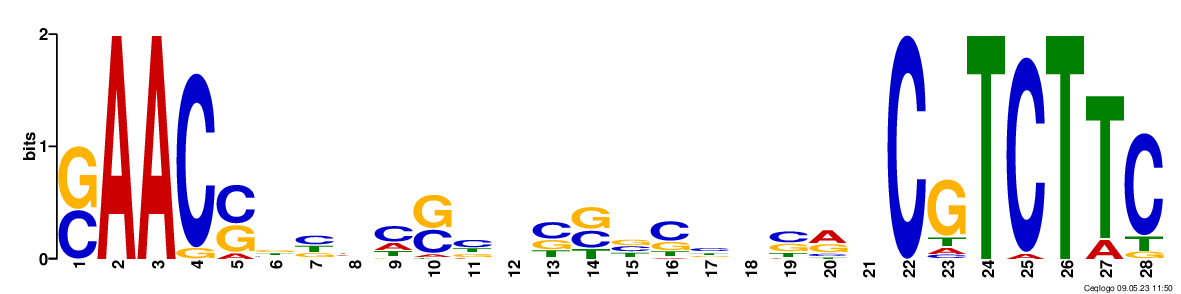

hsm_17


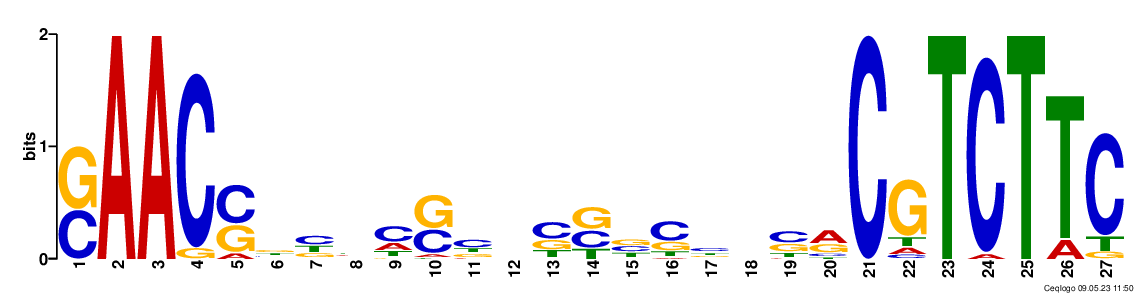

hsm_16


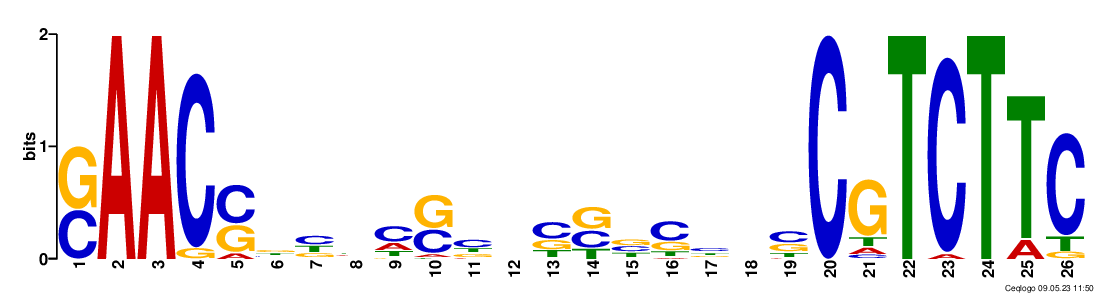

In [23]:
for motif in motifs:
    r = subprocess.call(
        ['ceqlogo', 
         '-i', os.path.join(temp, 'high_scoring_sites.meme'), 
         '-m', motif,
         '-f', 'PNG',
         '-o', os.path.join(temp, motif + '.png')
        ]
    )
    if r:
        raise ChildProcessError
        
    r = subprocess.call(
        ['ceqlogo', 
         '-i', os.path.join(temp, 'high_scoring_sites.meme'), 
         '-m', motif,
         '-f', 'EPS',
         '-o', os.path.join(temp, motif + '.eps')
        ]
    )
    if r:
        raise ChildProcessError
        
# todo show all motifs
for motif in motifs:
    print(motif)
    display(Image(os.path.join(temp, motif + '.png'), width=500))

In [24]:
# load the SigE peaks
df_e = pd.read_excel('data/sige_macs_peaks_curated.xlsx', sheet_name='sigE_peaks')
df_e

,start,end,length,abs_summit,pileup,neglog10pvalue,fold_enrichment,neglog10qvalue,norm/EtOH,sequence_name
0,8662666,8663025,360,8662837,4159.26,399.36166,2.10648,397.12149,1,sigE_0
1,8483428,8484106,679,8483707,9107.42,2952.46606,4.61191,2948.32202,1,sigE_1
2,8038581,8038938,358,8038755,6019.20,1160.16821,3.04824,1157.51782,1,sigE_2
3,8005927,8006952,1026,8006657,9276.34,1427.76892,2.65750,1425.00598,1,sigE_3
4,7885747,7886423,677,7886038,8795.63,2617.73657,4.26193,2614.10645,1,sigE_4
...,...,...,...,...,...,...,...,...,...,...
188,6107752,6107920,169,6107856,7593.41,1068.68542,2.52894,1066.07446,1,sigE_188
189,5999380,5999532,153,5999460,6709.26,833.43805,2.37112,830.94513,x,sigE_189
190,4336288,4336472,185,4336360,7307.68,841.24341,2.28611,838.74652,1,sigE_190
191,1869170,1869322,153,1869226,9659.11,3326.14575,4.89125,3321.38403,1,sigE_191


In [25]:
# process the dataframe
sigE_summits = {r.sequence_name: r.abs_summit for r in df_e.itertuples()}

peak_seqs2 = []
for id, s, e in df_e.loc[:, ['sequence_name', 'start', 'end']].values:
    peak_seqs2.append(
        '>{}-{}-{}\n{}\n'.format(id, s, e-s+1, str(sc_genome.seq[s:e]))
   )
with open(os.path.join(temp, 'sigE_peaks_whole.fasta'), 'w') as o:
    o.write('\n'.join(peak_seqs2))

In [26]:
%%bash
fimo --bfile $JUPYTER_TEMP/AL645882.2_m1.markov --oc $JUPYTER_TEMP/sigE_peaks_whole --thresh 0.05 $JUPYTER_TEMP/high_scoring_sites.meme $JUPYTER_TEMP/sigE_peaks_whole.fasta

Using motif +hsm_16 of width 26.
Using motif -hsm_16 of width 26.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.984138
Using motif +hsm_17 of width 27.
Using motif -hsm_17 of width 27.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.981573
Using motif +hsm_18 of width 28.
Using motif -hsm_18 of width 28.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.934419
Using motif +hsm_19 of width 29.
Using motif -hsm_19 of width 29.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.99


In [27]:
fimo_motif = pd.read_table(os.path.join(temp, 'sigE_peaks_whole', 'fimo.tsv'), comment='#')
fimo_motif['offset'] = fimo_motif.sequence_name.apply(lambda x: int(x.split('-')[1]))
fimo_motif['sequence_name'] = fimo_motif.sequence_name.apply(lambda x: x.split('-')[0])

fimo_motif_wf = fimo_motif.copy()
# skip filtering as JV wants to analyze the spacer properties

# basic filtering
# dropping simple duplicates while keeping hit with better p-val
_m = []
for (sname, strand), nn in fimo_motif.groupby(['sequence_name', 'strand']):
    rr = nn.sort_values('p-value').drop_duplicates('start').drop_duplicates('stop').copy()
    if strand == '+':
        rr['dist2abs_summit'] = abs((rr.start + rr.offset) - sigE_summits[sname])
    elif strand == '-':
        rr['dist2abs_summit'] = abs((rr.stop + rr.offset) - sigE_summits[sname])
    _m.append(rr)
fimo_motif = pd.concat(_m, axis=0).reset_index()

# but we still need to compute the distance 2 absolute summit
fimo_motif_wf['dist2abs_summit'] = float('NaN')
fip = fimo_motif_wf.loc[fimo_motif_wf.strand == '+']
fim = fimo_motif_wf.loc[fimo_motif_wf.strand == '-']
fimo_motif_wf.loc[fimo_motif_wf.strand == '+', 'dist2abs_summit'] = abs((fip.start + fip.offset) - [sigE_summits[i] for i in fip.sequence_name.values])
fimo_motif_wf.loc[fimo_motif_wf.strand == '-', 'dist2abs_summit'] = abs((fim.stop + fim.offset) - [sigE_summits[i] for i in fim.sequence_name.values])

In [28]:
features = pd.read_table(
    'data/GCA_000203835.1_ASM20383v1_genomic.gff', comment="#", names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
)

features = features.loc[features.seqid == SC_ACCESSION]

def gff_attributes_mapper(gff_attr):
    d = dict()
    for attr in gff_attr.split(';'):
        k,v = attr.split('=')
        d[k] = v
    return d

features = pd.concat([features, pd.DataFrame(map(lambda x:x, features.attributes.apply(gff_attributes_mapper)))], axis=1)
features = features.drop(columns=[
    'attributes', 'Dbxref', 'product', 'protein_id', 'transl_table', 'partial', 'gene_biotype', 'Parent', 'start_range',
    'regulatory_class', 'end_range', 'serovar', 'is_ordered', 'part', 'ID','mol_type', 'gbkey', 'old-name', 'bound_moiety', 'pseudo'
])
features.head()

,seqid,source,type,start,end,score,strand,phase,Note,Name,gene,gene_synonym
0,AL645882.2,EMBL,region,1,8667507,.,+,.,NaN,NaN,NaN,NaN
1,AL645882.2,EMBL,sequence_feature,1,21653,.,+,.,TIR-L. Left hand chromosome end terminal inver...,NaN,NaN,NaN
2,AL645882.2,EMBL,ribosome_entry_site,435,440,.,+,.,NaN,NaN,NaN,NaN
3,AL645882.2,EMBL,gene,446,1123,.,+,.,NaN,SCO0001,SCO0001,SCEND.02c
4,AL645882.2,EMBL,CDS,446,1123,.,+,0,SCEND.02c%2C unknown%2C doubtful CDS%2C len: 2...,CAD30875.1,SCO0001,NaN


In [29]:
def downstream_from_fimo(features, df, types=['gene', 'CDS', 'pseudogene']):
    nan = float('NaN')
    empty_rec = pd.Series({
        'seqid': nan,
        'source': nan,
        'type': nan,
        'start': nan,
        'end': nan,
        'score': nan,
        'strand': nan,
        'phase': nan,
        'Note': nan,
        'Name': nan,
        'gene': nan,
        'gene_synonym': nan,
        'dist2downstream': nan
    })
    
    features = features.copy()
    features['dist2downstream'] = 10*6    # some high value
    first_downstream = []
    for r in df.itertuples():       
        if r.strand == '+':
            sel = features.loc[(features.strand == r.strand) & (features.start > r.stop + r.offset) & (features.type.isin(types)), :]
            if len(sel) == 0:
                first_downstream.append(empty_rec)
                continue
            fr = sel.loc[sel.start.idxmin()].copy()
            fr['dist2downstream'] = fr.start - (r.stop + r.offset) - 1
        elif r.strand == '-':
            sel = features.loc[(features.strand == r.strand) & (features.end < r.start + r.offset) & (features.type.isin(types)), :]
            if len(sel) == 0:
                first_downstream.append(empty_rec)
                continue
            fr = sel.loc[sel.end.idxmax()].copy()
            fr['dist2downstream'] = (r.start + r.offset) - fr.end - 1
        else:
            raise NotImplementedError()
        
        first_downstream.append(fr)
    return pd.DataFrame().from_records(first_downstream)

In [30]:
first_downstream = downstream_from_fimo(features, fimo_motif)
first_downstream_wf = downstream_from_fimo(features, fimo_motif_wf)

In [31]:
fimo_motifs = pd.concat([fimo_motif, first_downstream.loc[:, ['gene', 'dist2downstream']]], axis=1)
fimo_motifs_wf = pd.concat([fimo_motif_wf, first_downstream_wf.loc[:, ['gene', 'dist2downstream']]], axis=1)

In [32]:
%%bash
fimo --bfile $JUPYTER_TEMP/AL645882.2_m1.markov --oc $JUPYTER_TEMP/fimo_hrdb_output --thresh 0.05 data/motifs/hrdb_-10_tr.meme $JUPYTER_TEMP/sigE_peaks_whole.fasta

Using motif +HrdB-10 of width 10.
Using motif -HrdB-10 of width 10.
Computing q-values.
  Estimating pi_0 from a uniformly sampled set of 10000 p-values.
  Estimating pi_0.
  Estimated pi_0=0.8918


In [33]:
# update
# select the HrdB sites as follows
# find the best one for each peak and strand and check if it is "Exact"

hrdb_sites = pd.read_table(os.path.join(temp, 'fimo_hrdb_output/fimo.tsv'), comment="#")
hrdb_sites = hrdb_sites.drop('motif_alt_id', axis=1)
hrdb_sites['offset'] = hrdb_sites.sequence_name.str.split('-').str[1].astype(int)
hrdb_sites.sequence_name = hrdb_sites.sequence_name.str.split('-').str[0]
hrdb_sites.head()

hrdb_sites['exact'] = False
hrdb_sites['best'] = False
hrdb_sites.loc[hrdb_sites.matched_sequence.apply(lambda x: (x[2] == "T") and (x[3] == "A") and (x[7] == "T")), 'exact'] = True
ex_hrdb_sites = hrdb_sites.loc[hrdb_sites.exact]

hrdb_sites.loc[hrdb_sites.groupby(['sequence_name', 'strand'])['p-value'].idxmin(), 'best'] = True
b_and_p_hrdb_sites = hrdb_sites.loc[hrdb_sites.exact & hrdb_sites.best].reset_index()

In [34]:
b_and_p_hrdb_sites.head()

,index,motif_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,offset,exact,best
0,0,HrdB-10,sigE_3,261,270,-,10.7797,0.000011,0.829,GGTACGATGG,8005927,True,True
1,1,HrdB-10,sigE_183,262,271,-,10.5254,0.000019,0.829,GTTAGACTGG,1969219,True,True
2,2,HrdB-10,sigE_58,295,304,-,10.4576,0.000021,0.829,GGTAAAGTGA,5474350,True,True
3,3,HrdB-10,sigE_85,946,955,-,10.2542,0.000039,0.829,GGTACCATGA,4325832,True,True
4,4,HrdB-10,sigE_172,821,830,-,10.1695,0.000042,0.829,GGTATAGTTG,3645245,True,True


In [35]:
hrdb_downstream_features = downstream_from_fimo(features, b_and_p_hrdb_sites)

In [36]:
hrdb_motifs = pd.concat([b_and_p_hrdb_sites, hrdb_downstream_features.loc[:, ['gene', 'dist2downstream']]], axis=1)
hrdb_motifs.head(2)

,index,motif_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,offset,exact,best,gene,dist2downstream
0,0,HrdB-10,sigE_3,261,270,-,10.7797,0.000011,0.829,GGTACGATGG,8005927,True,True,SCO7200,2071
1,1,HrdB-10,sigE_183,262,271,-,10.5254,0.000019,0.829,GTTAGACTGG,1969219,True,True,SCO1840,88


In [37]:
# filter fimo motifs
# for each sequence, strand and gene keep motifs closest to downstream and absolute summit
#  if those doesn't match, keep one with best p-val
selected_fimo_sites = []
for _, nn in fimo_motifs.groupby(['sequence_name', 'strand', 'gene']):
    if nn.dist2downstream.idxmin() == nn.dist2abs_summit.idxmin():
        bmi = nn.dist2downstream.idxmin()
    else:
        bmi = nn['p-value'].idxmin()
        
    selected_fimo_sites.append(nn.loc[bmi])
selected_fimo_motifs = pd.DataFrame().from_records(selected_fimo_sites)

In [38]:
sh_merge = pd.merge(
    selected_fimo_motifs.loc[:, ['sequence_name', 'strand', 'gene', 'start', 'stop', 'index']], 
    hrdb_motifs.loc[:, ['sequence_name', 'strand', 'gene', 'start', 'stop', 'index']],
    on=['sequence_name', 'strand', 'gene'],
    suffixes=['_s', '_h']
)
sh_merge['s_h'] = False
sh_merge.loc[sh_merge.strand == '+', 's_h'] = sh_merge.stop_s < sh_merge.start_h
sh_merge.loc[sh_merge.strand == '-', 's_h'] = sh_merge.start_s > sh_merge.stop_h

sh_merge['h_s'] = False
sh_merge.loc[sh_merge.strand == '+', 'h_s'] = sh_merge.stop_h < sh_merge.start_s
sh_merge.loc[sh_merge.strand == '-', 'h_s'] = sh_merge.start_h > sh_merge.stop_s

sh_merge['cat'] = 'NAN'
sh_merge.loc[sh_merge.s_h, 'cat'] = 'SHG'
sh_merge.loc[sh_merge.h_s, 'cat'] = 'HSG'
sh_merge.loc[(~sh_merge.s_h) & (~sh_merge.h_s), 'cat'] = 'O'
sh_merge.head()

,sequence_name,strand,gene,start_s,stop_s,index_s,start_h,stop_h,index_h,s_h,h_s,cat
0,sigE_101,+,SCO3322,541,566,200,1096,1105,40,True,False,SHG
1,sigE_101,-,SCO3320,943,968,205,639,648,39,True,False,SHG
2,sigE_102,+,SCO3203,1198,1224,54322,1203,1212,75,False,False,O
3,sigE_105,+,SCO3045,287,314,176,414,423,41,True,False,SHG
4,sigE_105,-,SCO3040,233,258,93,324,333,115,False,True,HSG


In [39]:
# get GC upstream 100
ud = 100
gc_100 = []
for r in selected_fimo_motifs.itertuples():
    if r.strand == '+':
        s = r.offset + r.start
        u = sc_genome.seq[s-ud:s]
    elif r.strand == '-':
        s = r.offset + r.stop
        u = sc_genome.seq[s:s+ud]
    else:
        raise NotImplementedError()
    gc = SeqUtils.GC(u)
    gc_100.append(gc)
    
selected_fimo_motifs['100_upstream_GC'] = gc_100

In [40]:
selected_fimo_motifs.head()

,index,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,offset,dist2abs_summit,gene,dist2downstream,100_upstream_GC
0,155,hsm_19,NaN,sigE_0,301,329,-,6.642860,1.890000e-05,0.29900,GGACGAGGTGCTCTGGCCGGCGCGTCTTG,8662666,158,SCO7843,1684.0,67.0
1,220,hsm_18,NaN,sigE_1,222,249,+,4.750000,3.470000e-05,0.06440,CAACCTCCGGCCATTTCCCACCTTCTGG,8483428,57,SCO7657,103.0,69.0
2,540,hsm_18,NaN,sigE_1,529,556,+,-0.119048,1.270000e-04,0.10900,GAAGGAGGACCCGGGCGTCTACCTCGAC,8483428,250,SCO7658,1573.0,74.0
3,2604,hsm_16,NaN,sigE_1,529,554,-,-7.559520,9.330000e-04,0.74400,CGAGGTAGACGCCCGGGTCCTCCTTC,8483428,275,SCO7653,3045.0,66.0
4,24,hsm_18,NaN,sigE_10,154,181,+,19.821400,1.390000e-07,0.00172,GAACGTCATAGCCGTCTGGTGCGTCTAC,7565074,29,SCO6812,9164.0,80.0


In [41]:
def sorter(df):
    df['sort'] = df.sequence_name.apply(lambda x: int(x.split('_')[1]))
    
    return df.sort_values('sort')\
             .drop(columns=['sort'])\
             .rename(columns={'dist2downstream': 'motif2gene_spacer_length'})

with pd.ExcelWriter(os.path.join(temp, 'sigE_conserved_motif.xlsx'), engine='xlsxwriter') as writer:
    
    sheetname = "sigE_peaks"
    desc = [
        "Columns as defined in sige_macs_peaks_curated.xlsx to allow identification based on 'sequence_name'",
    ]
    df_e.to_excel(writer, sheet_name=sheetname, startrow=len(desc)+1, index=False)
    for i, r in enumerate(desc):
        writer.sheets[sheetname].write(i, 0, r)
    
    desc = [
        "Motif sites for conserved Tran-like motif constructed from conserved motif sites discovered in sigE peaks sequences using MEME.",
        "Reported motif sites were found using fimo with p-val threshold of 0.05.",
        "Filtering:",
        "  - Duplicated motif sites based on start/stop removed, the one with lower p-value was kept.",
        "  - In case of multiple motif sites for same downstream gene, the one with lower distance to abs_summit and downstream gene was kept, if ambigous the one with lower p-value was kept.",
        "Columns:",
        "  index: motif_site identifier",
        "  motif_id: motif id (number indicates spacer length)",
        "  sequence_name: peak sequence id",
        "  start: motif site start position",
        "  stop: motif site stop position",
        "  strand: strand on which motif is found",
        "  score: fimo match score",
        "  p-value: motif site P-value (reported by fimo)",
        "  q-value: motif site q-value (reported by fimo)",
        "  matched_sequence: discovered motif site sequence 5'->3'",
        "  offset: sequence start position in genome",
        "  dist2abs_summit: distance from -10 start to peak summit (absolute value)",
        "  gene: first gene downstream from motif stop",
        "  motif2gene_spacer_length: length for a spacer between motif site and downstream gene [nt]",
        "  100_upstream_GC: GC content in percents for 100nt upstream from -35 start"
    ]
    sheetname = 'sigE motif sites'
    sorter(selected_fimo_motifs.drop(columns=['motif_alt_id'])).to_excel(writer, sheet_name=sheetname, startrow=len(desc) + 1, index=False)
    for i, row in enumerate(desc):
        writer.sheets[sheetname].write(i, 0, row)
    
    desc = [
        "Motif sites for conserved Tran-like motif constructed from conserved motif sites discovered in sigE peaks sequences using MEME.",
        "Reported motif sites were found using fimo with p-val threshold of 0.05.",
        "Filtering:",
        "  - No filtering applied.",
        "Columns:",
        "  index: motif_site identifier",
        "  motif_id: motif id (number indicates spacer length)",
        "  sequence_name: peak sequence id",
        "  start: motif site start position",
        "  stop: motif site stop position",
        "  strand: strand on which motif is found",
        "  score: fimo match score",
        "  p-value: motif site P-value (reported by fimo)",
        "  q-value: motif site q-value (reported by fimo)",
        "  matched_sequence: discovered motif site sequence 5'->3'",
        "  offset: sequence start position in genome",
        "  dist2abs_summit: distance from -10 start to peak summit (absolute value)",
        "  gene: first gene downstream from motif stop",
        "  motif2gene_spacer_length: length for a spacer between motif site and downstream gene [nt]",
    ]
    sheetname = 'sigE motif sites unfiltered'
    sorter(fimo_motifs_wf.drop(columns=['motif_alt_id'])).to_excel(writer, sheet_name=sheetname, startrow=len(desc) + 1, index=False)
    for i, row in enumerate(desc):
        writer.sheets[sheetname].write(i, 0, row)
    
    
    
    desc = [
        "Best scoring and exact HrdB sites in sigE peaks.",
        "The sites were found by fimo with HrdB motif, threshold 0.05, Streptomyces coelicolor background. Following motifs sites were selected:",
        "  1) motif site must contain --TA---T-- pattern",
        "  2) the best scoring motifs site (by p-value) on each sequence and strand",
        "Columns:",
        "  index:       hrdb motif site id",
        "  motif_id: motif id",
        "  sequence_name: peak sequence id",
        "  start: motif site start position",
        "  stop: motif site stop position",
        "  strand: strand on which motif is found",
        "  score: fimo match score",
        "  p-value: motif site P-value (reported by fimo)",
        "  q-value: motif site q-value (reported by fimo)",
        "  matched_sequence: discovered motif site sequence 5'->3'",
        "  offset: sequence start position in genome",
        "  exact:            bool wherther motif site was exact match to --TA---T--",
        "  best:             bool wherther motif site was best match on the sequence (by p-value)",
        "  gene: first gene downstream from motif stop",
        "  motif2gene_spacer_length: length for a spacer between motif site and downstream gene [nt]",
    ]
    sheetname = 'HrdB motif sites'
    sorter(hrdb_motifs).to_excel(writer, sheet_name=sheetname, startrow=len(desc) + 1, index=False)
    for i, row in enumerate(desc):
        writer.sheets[sheetname].write(i, 0, row)
    
    
    sheetname = 'sigE motif + HrdB motif'
    desc = [
        "Intersection of sigE motif sites and HrdB mofif sites.",
        " '_s' and '_h' suffixes respective for sigE and HrdB motif sites ",
        "Categories:",
        "  - HSG - order HrdB bs -> sigE bs -> downstream gene",
        "  - SHG - order sigE bs -> HrdB bs -> downstream gene",
        "  - O - ambigous - the binding sites ore overlapping each other."
        ""
        "Columns:",
        "  sequence_name: peak sequence id",
        "  strand: strand on which motif is found",
        "  gene: first gene downstream from motif stop",
        "  start[_s/_h]:  motif site start position",
        "  stop[_s/_h]:   motif site stop position",
        "  index[_/_h]:   motif site id",
        "  cat:  determined category",
    ]
    
    sorter(sh_merge.drop(columns=['s_h', 'h_s'])).to_excel(writer, sheet_name=sheetname, startrow=len(desc) + 1, index=False)
    for i, row in enumerate(desc):
        writer.sheets[sheetname].write(i, 0, row)
